In [189]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('results/all_results_concat.csv')
df_half_bp = df.copy()

#### top models

In [218]:
def top_models(df):
    df = df.copy()

    df['is_correct'] = df['score'].apply(
        lambda x: 1 if str(x).strip().lower() == 'right'
        else 0.5 if str(x).strip().lower() == 'somewhat right'
        else 0
    )

    df_filtered = df[[
        "problem_id",
        "dataset_name",
        "model_name",
        "strategy_name",
        "version",
        "is_correct"
    ]]

    df_filtered = df_filtered.dropna().drop_duplicates(
        subset=[
            "dataset_name",
            "model_name",
            "strategy_name",
            "problem_id",
            "version"
        ],
        keep="last"
    )

    score_by_problem = (
        df_filtered
        .groupby(["model_name", "version", "strategy_name"])["is_correct"]
        .sum()
    )

    # ---- Top 10 printed as before ----
    top_10 = score_by_problem.sort_values(ascending=False).head(10)
    print(top_10)

    # ---- Top 5 list in requested format ----
    top_5_list = [
        [f"{strategy}", f"{model}", f"{version}"]
        for (model, version, strategy) in
        score_by_problem.sort_values(ascending=False).head(5).index
    ]

    print("\nTop 5 [\"strategy\", \"model\", \"version\"]:")
    print(top_5_list)


    return top_5_list


In [219]:
top_models(df)

bp_only = df[df["dataset_name"]=="bp"].copy()
bp_only = bp_only[bp_only["strategy_name"]!="classification"]
cvr_only = df[df["dataset_name"]=="cvr"].copy()
raven_only = df[df["dataset_name"]=="raven"].copy()
mars_only = df[df["dataset_name"]=="marsvqa"].copy()

print("\n ------------ BP -------------\n")
top_models(bp_only)
print("\n ------------ CVR -------------\n")
top_models(cvr_only)
print("\n ------------ RAVEN -------------\n")
top_models(raven_only)
print("\n ------------ MARS -------------\n")
top_models(mars_only)

model_name                   version  strategy_name 
Qwen/Qwen2.5-VL-7B-Instruct  3        direct            196.0
                                      contrastive       193.0
                             1        direct            190.5
                                      contrastive       172.5
OpenGVLab/InternVL3-8B       1        direct            126.0
                                      descriptive       124.0
Qwen/Qwen2.5-VL-7B-Instruct  1        classification    122.0
                             3        classification    119.0
OpenGVLab/InternVL3-8B       3        direct            117.5
                                      descriptive       117.0
Name: is_correct, dtype: float64

Top 5 ["strategy", "model", "version"]:
[['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['direct', 'OpenGVLab/InternVL3-8B', '1']]

 -----

[['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'],
 ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'],
 ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'],
 ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'],
 ['contrastive', 'OpenGVLab/InternVL3-8B', '3']]

#### random shit

In [221]:
def top_by_group(df, type='models'):
    df = df.copy()

    # --- score mapping ---
    df['is_correct'] = df['score'].apply(
        lambda x: 1 if str(x).strip().lower() == 'right'
        else 0.5 if str(x).strip().lower() == 'somewhat right'
        else 0
    )

    # --- select & dedupe ---
    df_filtered = df[[
        "problem_id",
        "dataset_name",
        "model_name",
        "strategy_name",
        "version",
        "is_correct"
    ]]

    df_filtered = df_filtered.dropna().drop_duplicates(
        subset=[
            "dataset_name",
            "model_name",
            "strategy_name",
            "problem_id",
            "version"
        ],
        keep="last"
    )

    # --- aggregate ---
    score = (
        df_filtered
        .groupby(["model_name", "strategy_name", "version"])["is_correct"]
        .sum()
        .reset_index()
    )

    if type == 'models':
        group_col = "strategy_name"
        rank_cols = ["model_name", "version"]
        label = "strategy"

    elif type == 'strategies':
        group_col = "model_name"
        rank_cols = ["strategy_name", "version"]
        label = "model"

    else:
        raise ValueError("type must be 'models' or 'strategies'")

    # --- rank within group ---
    score["rank"] = (
        score
        .groupby(group_col)["is_correct"]
        .rank(method="first", ascending=False)
    )

    top_2 = score[score["rank"] <= 2].sort_values(
        [group_col, "rank"]
    )

    print(f"\nTop 2 per {label}:")
    print(top_2[[group_col] + rank_cols + ["is_correct", "rank"]])

    # --- extract top 1 list ---
    top_1_list = [
        [row[group_col], row[rank_cols[0]], row[rank_cols[1]]]
        for _, row in top_2[top_2["rank"] == 1].iterrows()
    ]

    print(f"\nTop 1 from each {label}:")
    print(top_1_list)

    return top_2, top_1_list


In [222]:
bp_only = df[df["dataset_name"]=="bp"].copy()
bp_only = bp_only[bp_only["strategy_name"]!="classification"]
cvr_only = df[df["dataset_name"]=="cvr"].copy()
raven_only = df[df["dataset_name"]=="raven"].copy()
mars_only = df[df["dataset_name"]=="marsvqa"].copy()

print("\n ------------ BP -------------\n")
top_by_group(bp_only)
print("\n ------------ CVR -------------\n")
top_by_group(cvr_only)
print("\n ------------ RAVEN -------------\n")
top_by_group(raven_only)
print("\n ------------ MARS -------------\n")
top_by_group(mars_only)


 ------------ BP -------------


Top 2 per strategy:
   strategy_name                   model_name  version  is_correct  rank
9    contrastive  Qwen/Qwen2.5-VL-7B-Instruct        1        40.5   1.0
11   contrastive  Qwen/Qwen2.5-VL-7B-Instruct        3        36.0   2.0
3    descriptive       OpenGVLab/InternVL3-8B        1        41.0   1.0
12   descriptive  Qwen/Qwen2.5-VL-7B-Instruct        1        40.5   2.0
6         direct       OpenGVLab/InternVL3-8B        1        44.0   1.0
8         direct       OpenGVLab/InternVL3-8B        3        42.5   2.0

Top 1 from each strategy:
[['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', 1], ['descriptive', 'OpenGVLab/InternVL3-8B', 1], ['direct', 'OpenGVLab/InternVL3-8B', 1]]

 ------------ CVR -------------


Top 2 per strategy:
     strategy_name                   model_name  version  is_correct  rank
8   classification  Qwen/Qwen2.5-VL-7B-Instruct        1          43   1.0
1   classification       OpenGVLab/InternVL3-8B        3        

(                           model_name   strategy_name  version  is_correct  \
 17  llava-hf/llava-v1.6-mistral-7b-hf  classification        3          30   
 9         Qwen/Qwen2.5-VL-7B-Instruct  classification        3          27   
 10        Qwen/Qwen2.5-VL-7B-Instruct     contrastive        1          36   
 11        Qwen/Qwen2.5-VL-7B-Instruct     contrastive        3          35   
 5              OpenGVLab/InternVL3-8B     descriptive        3          27   
 20  llava-hf/llava-v1.6-mistral-7b-hf     descriptive        1          26   
 14        Qwen/Qwen2.5-VL-7B-Instruct          direct        1          43   
 15        Qwen/Qwen2.5-VL-7B-Instruct          direct        3          37   
 
     rank  
 17   1.0  
 9    2.0  
 10   1.0  
 11   2.0  
 5    1.0  
 20   2.0  
 14   1.0  
 15   2.0  ,
 [['classification', 'llava-hf/llava-v1.6-mistral-7b-hf', 3],
  ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', 1],
  ['descriptive', 'OpenGVLab/InternVL3-8B', 3],
  ['direct', 'Q

#### for ensembles - configs

In [ ]:
def top_model_versions_per_strategy(df):
    df = df.copy()

    # ---- Scoring logic ----
    df["is_correct"] = df["score"].apply(
        lambda x: 1 if str(x).strip().lower() == "right"
        else 0.5 if str(x).strip().lower() == "somewhat right"
        else 0
    )

    df = df[[
        "problem_id",
        "dataset_name",
        "model_name",
        "strategy_name",
        "version",
        "is_correct"
    ]]

    df = df.dropna().drop_duplicates(
        subset=[
            "dataset_name",
            "model_name",
            "strategy_name",
            "problem_id",
            "version"
        ],
        keep="last"
    )

    # ---- Aggregate score per (strategy, model, version) ----
    scores = (
        df
        .groupby(["strategy_name", "model_name", "version"])["is_correct"]
        .sum()
        .reset_index()
    )

    result = []

    # ---- For each strategy → for each model → best version ----
    for strategy, g_strategy in scores.groupby("strategy_name"):
        for model, g_model in g_strategy.groupby("model_name"):
            top = (
                g_model
                .sort_values("is_correct", ascending=False)
                .iloc[0]
            )

            result.append([
                strategy,
                model,
                top["version"]
            ])

    print('Top 1 version per model per strategy ["strategy", "model", "version"]:')
    formatted = [[s, m, str(v)] for s, m, v in result]
    print(formatted)

    return result


In [227]:
reslut = top_model_versions_per_strategy(df)

Top 1 version per model per strategy ["strategy", "model", "version"]:
[['classification', 'OpenGVLab/InternVL3-8B', '1'], ['classification', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['classification', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['contrastive', 'OpenGVLab/InternVL3-8B', '3'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['contrastive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['descriptive', 'OpenGVLab/InternVL3-8B', '1'], ['descriptive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['descriptive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['direct', 'OpenGVLab/InternVL3-8B', '1'], ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['direct', 'llava-hf/llava-v1.6-mistral-7b-hf', '1']]


In [228]:
def top_strategy_versions_per_model(df):
    df = df.copy()

    # ---- Scoring logic ----
    df["is_correct"] = df["score"].apply(
        lambda x: 1 if str(x).strip().lower() == "right"
        else 0.5 if str(x).strip().lower() == "somewhat right"
        else 0
    )

    df = df[[
        "problem_id",
        "dataset_name",
        "model_name",
        "strategy_name",
        "version",
        "is_correct"
    ]]

    df = df.dropna().drop_duplicates(
        subset=[
            "dataset_name",
            "model_name",
            "strategy_name",
            "problem_id",
            "version"
        ],
        keep="last"
    )

    # ---- Aggregate score per (strategy, model, version) ----
    scores = (
        df
        .groupby(["strategy_name", "model_name", "version"])["is_correct"]
        .sum()
        .reset_index()
    )

    result = []

    # ---- For each strategy → for each model → best version ----
    for model, g_model in scores.groupby("model_name"):
        for strategy, g_strategy in g_model.groupby("strategy_name"):
            top = (
                g_strategy
                .sort_values("is_correct", ascending=False)
                .iloc[0]
            )

            result.append([
                strategy,
                model,
                top["version"]
            ])

    print('Top 1 version per model per strategy ["strategy", "model", "version"]:')
    formatted = [[s, m, str(v)] for s, m, v in result]
    print(formatted)

    return result


In [230]:
result = top_strategy_versions_per_model(df)

Top 1 version per model per strategy ["strategy", "model", "version"]:
[['classification', 'OpenGVLab/InternVL3-8B', '1'], ['contrastive', 'OpenGVLab/InternVL3-8B', '3'], ['descriptive', 'OpenGVLab/InternVL3-8B', '1'], ['direct', 'OpenGVLab/InternVL3-8B', '1'], ['classification', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['descriptive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['classification', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['contrastive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['descriptive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['direct', 'llava-hf/llava-v1.6-mistral-7b-hf', '1']]


#### random analysis

In [115]:
def perform_thorough_analysis(df, half_points_bp = False):
    print("--- Unique Models and Strategies ---")
    print(f"Models: {df['model_name'].unique().tolist()}")
    print(f"Strategies: {df['strategy_name'].unique().tolist()}\n")

    if half_points_bp:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right'
            else 0.5 if str(x).strip().lower() == 'somewhat right'
            else 0
        )
    else:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right' else 0
        )

    print("--- Performance Metrics by Configuration ---")
    metrics = df.groupby(['dataset_name', 'model_name', 'strategy_name', 'version']).agg({
        'is_correct': 'mean',
        'confidence': 'mean',
        'problem_id': 'count'
    }).rename(columns={
        'is_correct': 'accuracy',
        'confidence': 'avg_confidence',
        'problem_id': 'total_questions'
    })
    
    # Calculate Calibration Gap (Confidence - Accuracy)
    # A positive number indicates overconfidence
    metrics['calibration_gap'] = metrics['avg_confidence'] - metrics['accuracy']
    print(metrics.head(10))
    print("\n")

    print("--- Model Performance Analysis ---")

    type_analysis = df.groupby(['dataset_name', 'model_name']).agg({
        'is_correct': 'mean',
        'confidence': 'mean'
    }).rename(columns={'is_correct': 'accuracy'})
    print(type_analysis)

    type_analysis = df.groupby(['model_name']).agg({
        'is_correct': 'mean',
        'confidence': 'mean'
    }).rename(columns={'is_correct': 'accuracy'})
    print(type_analysis)

    print("--- Strategy Performance Analysis ---")

    type_analysis = df.groupby(['dataset_name', 'strategy_name']).agg({
        'is_correct': 'mean',
        'confidence': 'mean'
    }).rename(columns={'is_correct': 'accuracy'})
    print(type_analysis)

    type_analysis = df.groupby(['strategy_name']).agg({
        'is_correct': 'mean',
        'confidence': 'mean'
    }).rename(columns={'is_correct': 'accuracy'})
    print(type_analysis)

    print("--- Confidence Calibration (Binned) ---")
    # Groups confidence into 10% bins to see if high confidence actually correlates with accuracy
    df['conf_bin'] = pd.cut(df['confidence'], bins=np.linspace(0, 1, 11))
    calibration = df.groupby('conf_bin').agg({
        'is_correct': ['mean', 'count']
    })
    calibration.columns = ['accuracy', 'count']
    print(calibration.dropna())

# Run the analysis
perform_thorough_analysis(df)
perform_thorough_analysis(df_half_bp, True)

--- Unique Models and Strategies ---
Models: [nan, 'Qwen/Qwen2.5-VL-7B-Instruct', 'llava-hf/llava-v1.6-mistral-7b-hf', 'OpenGVLab/InternVL3-8B']
Strategies: [nan, 'classification', 'direct', 'descriptive', 'contrastive']

--- Performance Metrics by Configuration ---
                                                            accuracy  \
dataset_name model_name             strategy_name  version             
bp           OpenGVLab/InternVL3-8B classification 1            0.38   
                                                   2            0.51   
                                                   3            0.43   
                                    contrastive    1            0.06   
                                                   2            0.01   
                                                   3            0.03   
                                    descriptive    1            0.09   
                                                   2            0.05   
             

#### functions for matrix plotting

In [141]:
import pandas as pd

def generate_10x10_result_matrix(
    df,
    version=None,
    dataset_name=None,
    strategy_name=None,
    model_name=None,
):
    # -------------------------
    # Base filtering
    # -------------------------
    df_filtered = df[[
        "problem_id",
        "dataset_name",
        "model_name",
        "strategy_name",
        "version",
        "is_correct"
    ]].dropna()

    # Optional filters
    if version is not None:
        df_filtered = df_filtered[df_filtered["version"] == version]

    if dataset_name is not None:
        df_filtered = df_filtered[df_filtered["dataset_name"] == dataset_name]

    if strategy_name is not None:
        df_filtered = df_filtered[df_filtered["strategy_name"] == strategy_name]

    if model_name is not None:
        df_filtered = df_filtered[df_filtered["model_name"] == model_name]

    # -------------------------
    # Deduplicate safely
    # -------------------------
    df_filtered = df_filtered.drop_duplicates(
        subset=[
            "dataset_name",
            "model_name",
            "strategy_name",
            "problem_id",
            "version"
        ],
        keep="last"
    )

    # -------------------------
    # Compute sum of is_correct
    # -------------------------
    score_by_problem = (
        df_filtered
        .groupby("problem_id")["is_correct"]
        .sum()
    )

    # -------------------------
    # Build labeled 10x10 matrix
    # -------------------------
    matrix = pd.DataFrame(0, index=range(10), columns=range(10))

    for problem_id, score in score_by_problem.items():
        row = (problem_id - 1) // 10
        col = (problem_id - 1) % 10
        if 0 <= row < 10 and 0 <= col < 10:
            matrix.loc[row, col] = score

    # Label rows / columns
    matrix.index = [f"Row {i*10+1}-{i*10+10}" for i in range(10)]
    matrix.columns = [f"Problem {i+1}" for i in range(10)]

    return matrix


In [155]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def plot_10x10_matrices_side_by_side(
    matrices,
    titles,
    max_score,
    main_title,
    highlight_extremes=False,
    zero_indexed_problem_ids=False
):
    """
    zero_indexed_problem_ids:
        False → problem IDs 1–100
        True  → problem IDs 0–99
    """

    assert 1 <= len(matrices) <= 3
    assert len(matrices) == len(titles)

    n = len(matrices)

    fig, axes = plt.subplots(
        2, n,
        figsize=(6 * n, 9),
        gridspec_kw={"height_ratios": [4, 1]},
        sharey="row"
    )

    if n == 1:
        axes = axes.reshape(2, 1)

    cmap = LinearSegmentedColormap.from_list(
        "white_to_green",
        ["#ffffff", "#006400"]
    )

    im = None

    def problem_id(i, j):
        base = i * 10 + j
        return int(base if zero_indexed_problem_ids else base + 1)

    # ---------------- main loop ----------------
    for idx, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[0, idx]
        hist_ax = axes[1, idx]

        values = matrix.values

        # ----- heatmap -----
        im = ax.imshow(
            values,
            cmap=cmap,
            vmin=0,
            vmax=max_score
        )

        if highlight_extremes:
            zero_cells = np.argwhere(values == 0)

            flat_indices = np.argsort(values, axis=None)[-3:]
            top3_cells = [np.unravel_index(i, values.shape) for i in flat_indices]

            zero_problem_ids = sorted(problem_id(i, j) for i, j in zero_cells)

        # ----- cell labels + borders -----
        for i in range(10):
            for j in range(10):
                pid = problem_id(i, j)

                ax.text(
                    j, i, str(pid),
                    ha="center", va="center",
                    fontsize=9,
                    color="black"
                )

                if highlight_extremes:
                    if values[i, j] == 0:
                        ax.add_patch(
                            plt.Rectangle(
                                (j - 0.5, i - 0.5), 1, 1,
                                fill=False, edgecolor="red", linewidth=2
                            )
                        )

                    if (i, j) in top3_cells:
                        ax.add_patch(
                            plt.Rectangle(
                                (j - 0.5, i - 0.5), 1, 1,
                                fill=False, edgecolor="blue", linewidth=2
                            )
                        )

        ax.set_title(title)
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.set_xticklabels(range(0, 10) if zero_indexed_problem_ids else range(1, 11))

        # ----- histogram -----
        flat_values = values.flatten()
        bins = np.arange(0, max_score + 2) - 0.5

        hist_ax.hist(
            flat_values,
            bins=bins,
            color="#9ecae1",      # light blue
            edgecolor="#08519c",  # darker blue
            linewidth=1,
            alpha=0.8
        )

        hist_ax.set_xlim(-0.5, max_score + 0.5)
        hist_ax.set_xlabel("is_correct score")
        hist_ax.set_ylabel("Count")
        hist_ax.set_title("Score distribution")

        # ----- console output -----
        if highlight_extremes:
            print(f"\n{title}")
            print("-" * len(title))

            print(f"Zero-value problems : {len(zero_problem_ids)}")
            if zero_problem_ids:
                print(f"  → {zero_problem_ids}")
            else:
                print("  → None")

            print("Top 3 problems (problem_id : is_correct)")
            for i, j in top3_cells:
                pid = problem_id(i, j)
                print(f"  → {pid} : {values[i, j]}")

            total_score = values.sum()
            max_possible = 100 * max_score
            pct = 100 * total_score / max_possible if max_possible else 0

            print(f"Total score          : {int(total_score)} / {max_possible}")
            print(f"Percentage achieved  : {pct:.2f}%")

    # ----- Y-axis labels -----
    if zero_indexed_problem_ids:
        y_labels = [f"{i*10}-{i*10+9}" for i in range(10)]
    else:
        y_labels = [f"{i*10+1}-{i*10+10}" for i in range(10)]

    axes[0, 0].set_yticklabels(y_labels)
    axes[0, 0].set_ylabel("Problem ID range")

    for col in range(n):
        axes[0, col].set_xlabel("Problem (within block)")

    # ----- colorbar sized to heatmaps only -----
    cbar = fig.colorbar(
        im,
        ax=axes[0, :],   # ⬅ only the top row
        fraction=0.035,
        pad=0.04
    )
    cbar.set_label("Sum of is_correct")

    fig.suptitle(main_title, fontsize=14)
    plt.show()


#### overall matrix - datasets


CVR
---
Zero-value problems : 1
  → [99]
Top 3 problems (problem_id : is_correct)
  → 79 : 12
  → 81 : 13
  → 63 : 14
Total score          : 688 / 2400
Percentage achieved  : 28.67%

RAVEN
-----
Zero-value problems : 2
  → [37, 99]
Top 3 problems (problem_id : is_correct)
  → 53 : 10
  → 22 : 10
  → 20 : 11
Total score          : 611 / 2400
Percentage achieved  : 25.46%

MARS
----
Zero-value problems : 1
  → [99]
Top 3 problems (problem_id : is_correct)
  → 87 : 12
  → 70 : 12
  → 58 : 15
Total score          : 641 / 2400
Percentage achieved  : 26.71%


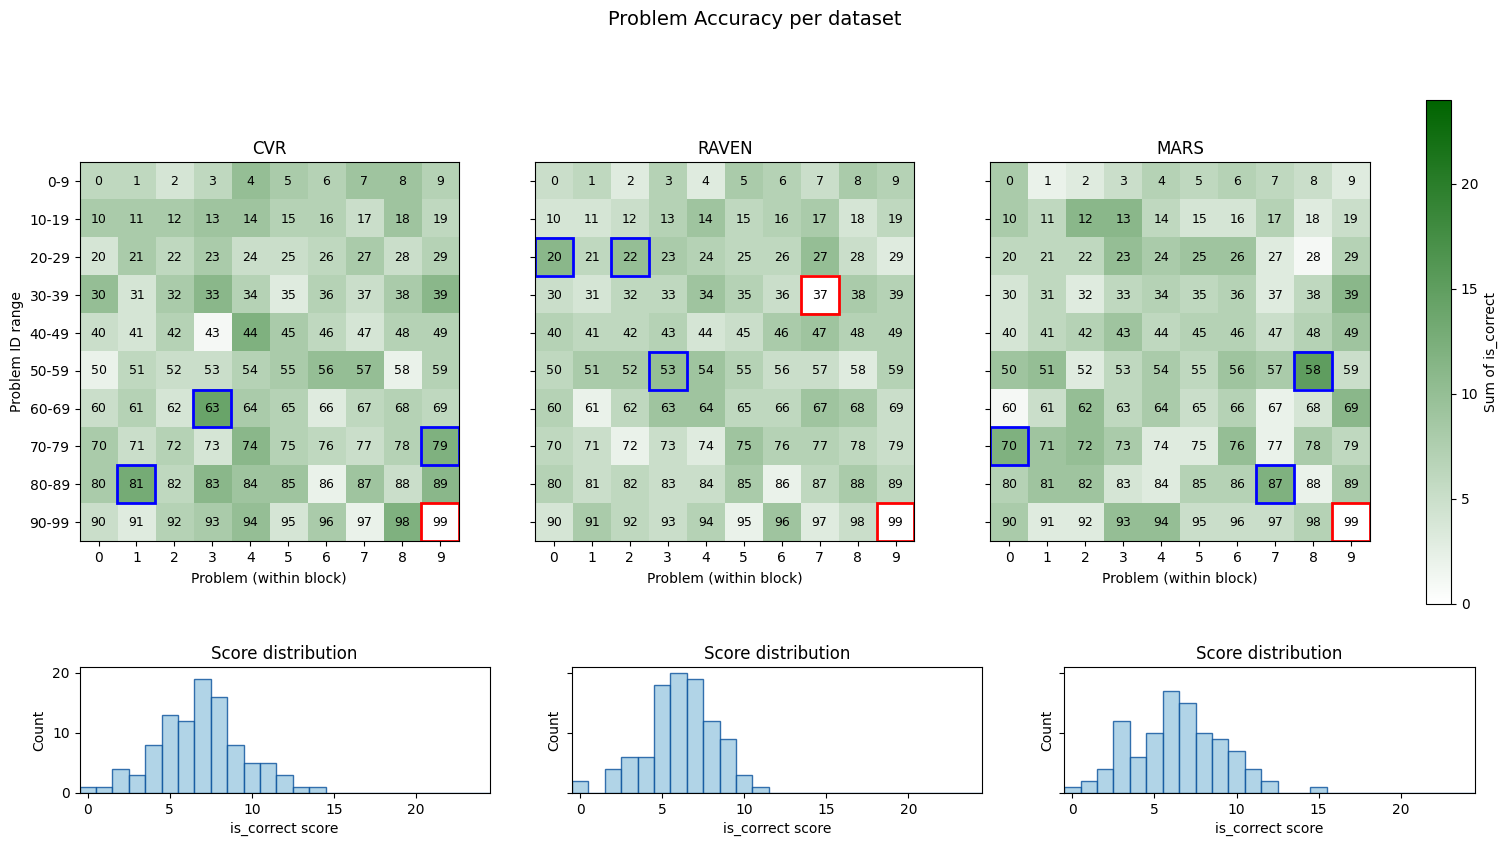

In [156]:
m1 = generate_10x10_result_matrix(df, dataset_name="cvr")
m2 = generate_10x10_result_matrix(df, dataset_name="raven")
m3 = generate_10x10_result_matrix(df, dataset_name="marsvqa")
plot_10x10_matrices_side_by_side([m1,m2,m3],["CVR", "RAVEN", "MARS"],max_score=24, main_title="Problem Accuracy per dataset",highlight_extremes=True, zero_indexed_problem_ids=True)


BP
--
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 42 : 22.0
  → 72 : 22.0
  → 47 : 22.5
Total score          : 1397 / 3600
Percentage achieved  : 38.82%


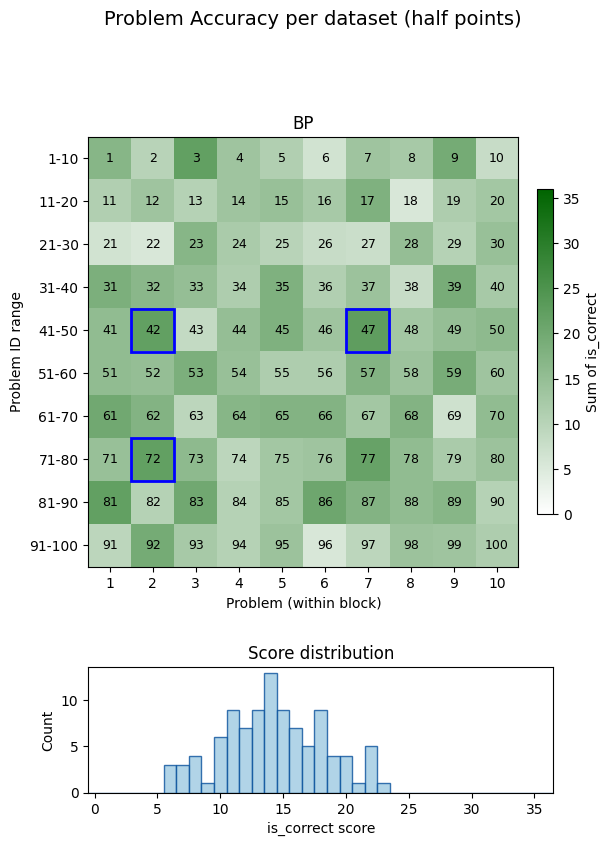

In [158]:
m1 = generate_10x10_result_matrix(df_half_bp, dataset_name="bp")
plot_10x10_matrices_side_by_side([m1],["BP"],max_score=36, main_title="Problem Accuracy per dataset (half points)",highlight_extremes=True)

#### overall matrices - models


Qwen
----
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 49 : 17
  → 38 : 19
  → 23 : 19
Total score          : 1071 / 3600
Percentage achieved  : 29.75%

Intern
------
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 44 : 14
  → 63 : 15
  → 85 : 15
Total score          : 764 / 3600
Percentage achieved  : 21.22%

Llava
-----
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 50 : 11
  → 53 : 11
  → 24 : 13
Total score          : 625 / 3600
Percentage achieved  : 17.36%


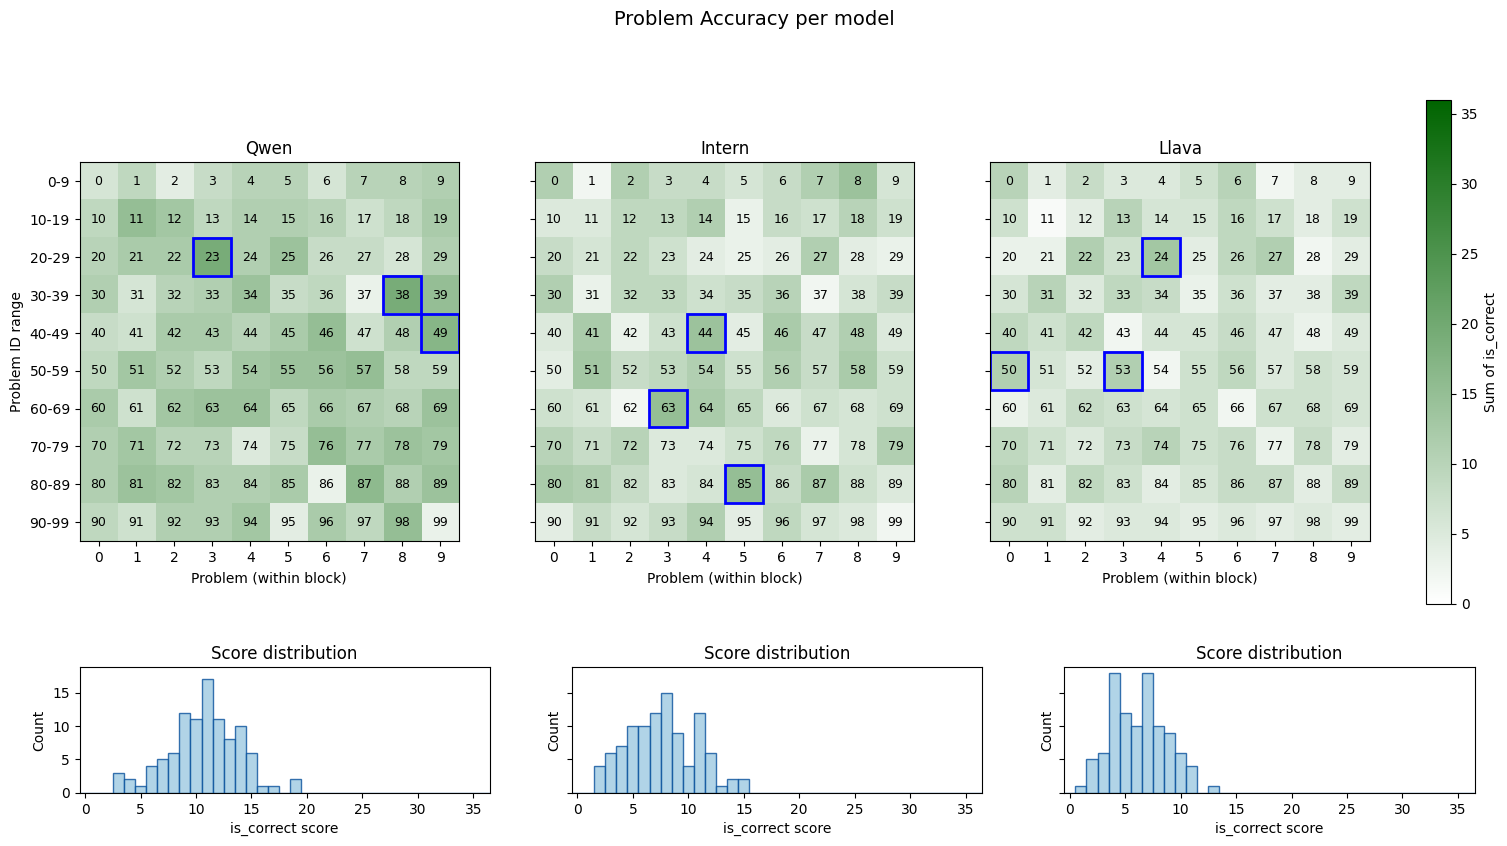

In [160]:
# 'Qwen/Qwen2.5-VL-7B-Instruct', 'llava-hf/llava-v1.6-mistral-7b-hf', 'OpenGVLab/InternVL3-8B'
m1 = generate_10x10_result_matrix(df, model_name="Qwen/Qwen2.5-VL-7B-Instruct")
m2 = generate_10x10_result_matrix(df, model_name="OpenGVLab/InternVL3-8B")
m3 = generate_10x10_result_matrix(df, model_name="llava-hf/llava-v1.6-mistral-7b-hf")
plot_10x10_matrices_side_by_side([m1,m2,m3],["Qwen", "Intern", "Llava"], max_score=36, main_title="Problem Accuracy per model",highlight_extremes=True, zero_indexed_problem_ids=True)

#### overall matrices - strategies

In [185]:
no_bp_df = df[df["dataset_name"] != "bp"].copy()
standard_only = no_bp_df[no_bp_df["dataset_name"] != "cvr"].copy()


direct
------
Zero-value problems : 2
  → [37, 99]
Top 3 problems (problem_id : is_correct)
  → 38 : 7
  → 39 : 7
  → 94 : 7
Total score          : 400 / 1200
Percentage achieved  : 33.33%

descriptive
-----------
Zero-value problems : 9
  → [18, 37, 56, 68, 75, 84, 89, 92, 99]
Top 3 problems (problem_id : is_correct)
  → 48 : 5
  → 51 : 5
  → 93 : 5
Total score          : 254 / 1200
Percentage achieved  : 21.17%

contrastive
-----------
Zero-value problems : 2
  → [19, 99]
Top 3 problems (problem_id : is_correct)
  → 43 : 7
  → 87 : 7
  → 76 : 7
Total score          : 382 / 1200
Percentage achieved  : 31.83%


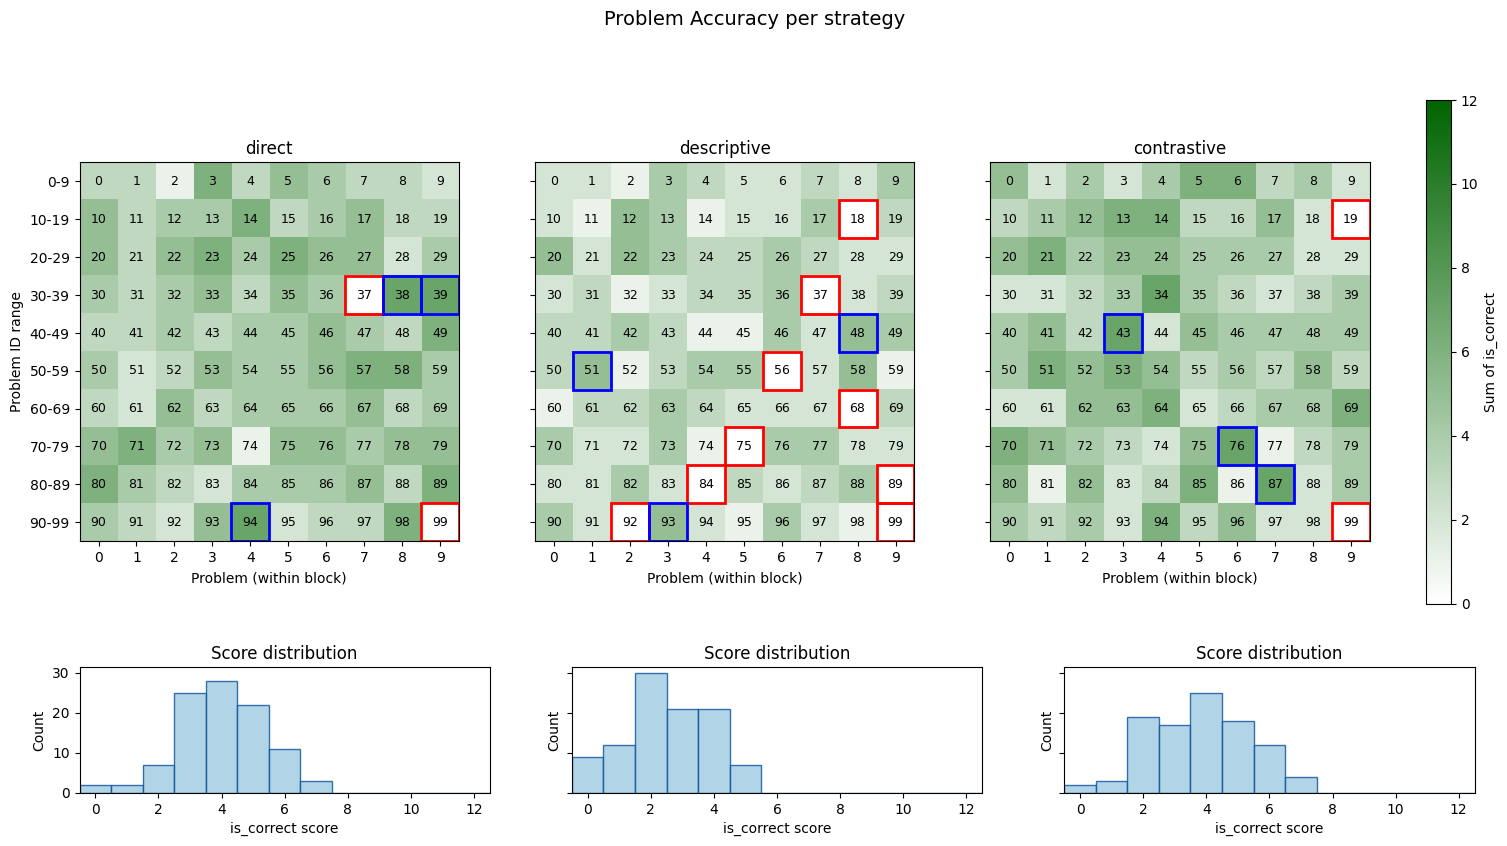

In [187]:
def generate_strategy_plots(df):
    m1 = generate_10x10_result_matrix(df, strategy_name="direct")
    m2 = generate_10x10_result_matrix(df, strategy_name="descriptive")
    m3 = generate_10x10_result_matrix(df, strategy_name="contrastive")
    plot_10x10_matrices_side_by_side([m1,m2,m3],["direct", "descriptive", "contrastive"], max_score=12, main_title="Problem Accuracy per strategy",highlight_extremes=True, zero_indexed_problem_ids=True)

#generate_strategy_plots(df)
generate_strategy_plots(standard_only)


classification
--------------
Zero-value problems : 10
  → [2, 3, 4, 28, 61, 67, 77, 79, 90, 99]
Top 3 problems (problem_id : is_correct)
  → 51 : 5
  → 68 : 5
  → 81 : 7
Total score          : 216 / 1200
Percentage achieved  : 18.00%


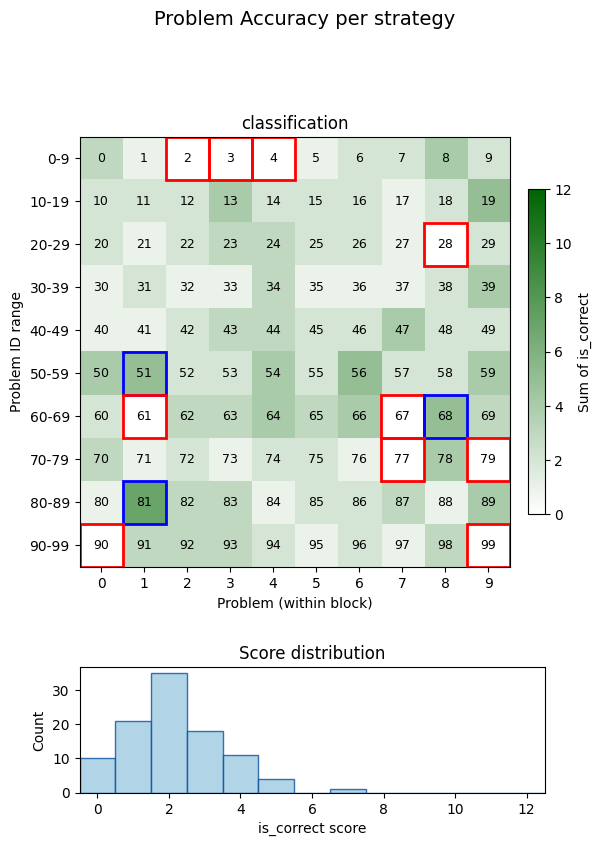

In [188]:
def generate_strategy_plots_class(df):
    m1 = generate_10x10_result_matrix(df, strategy_name="classification")
    plot_10x10_matrices_side_by_side([m1],["classification"], max_score=12, main_title="Problem Accuracy per strategy",highlight_extremes=True, zero_indexed_problem_ids=True)

generate_strategy_plots_class(standard_only)

#### matrices for bp 


Version 1
---------
Zero-value problems : 18
  → [2, 5, 6, 7, 9, 11, 13, 18, 21, 27, 38, 46, 60, 63, 75, 80, 94, 95]
Top 3 problems (problem_id : is_correct)
  → 81 : 5
  → 61 : 6
  → 47 : 6
Total score          : 192 / 1200
Percentage achieved  : 16.00%

Version 2
---------
Zero-value problems : 17
  → [2, 6, 14, 21, 22, 26, 27, 29, 30, 43, 44, 48, 50, 82, 91, 96, 99]
Top 3 problems (problem_id : is_correct)
  → 98 : 3
  → 47 : 4
  → 3 : 6
Total score          : 174 / 1200
Percentage achieved  : 14.50%

Version 3
---------
Zero-value problems : 30
  → [4, 10, 11, 12, 14, 15, 18, 21, 22, 26, 27, 29, 30, 38, 40, 55, 67, 69, 70, 71, 76, 78, 82, 84, 90, 94, 95, 96, 97, 99]
Top 3 problems (problem_id : is_correct)
  → 47 : 4
  → 57 : 4
  → 83 : 4
Total score          : 154 / 1200
Percentage achieved  : 12.83%


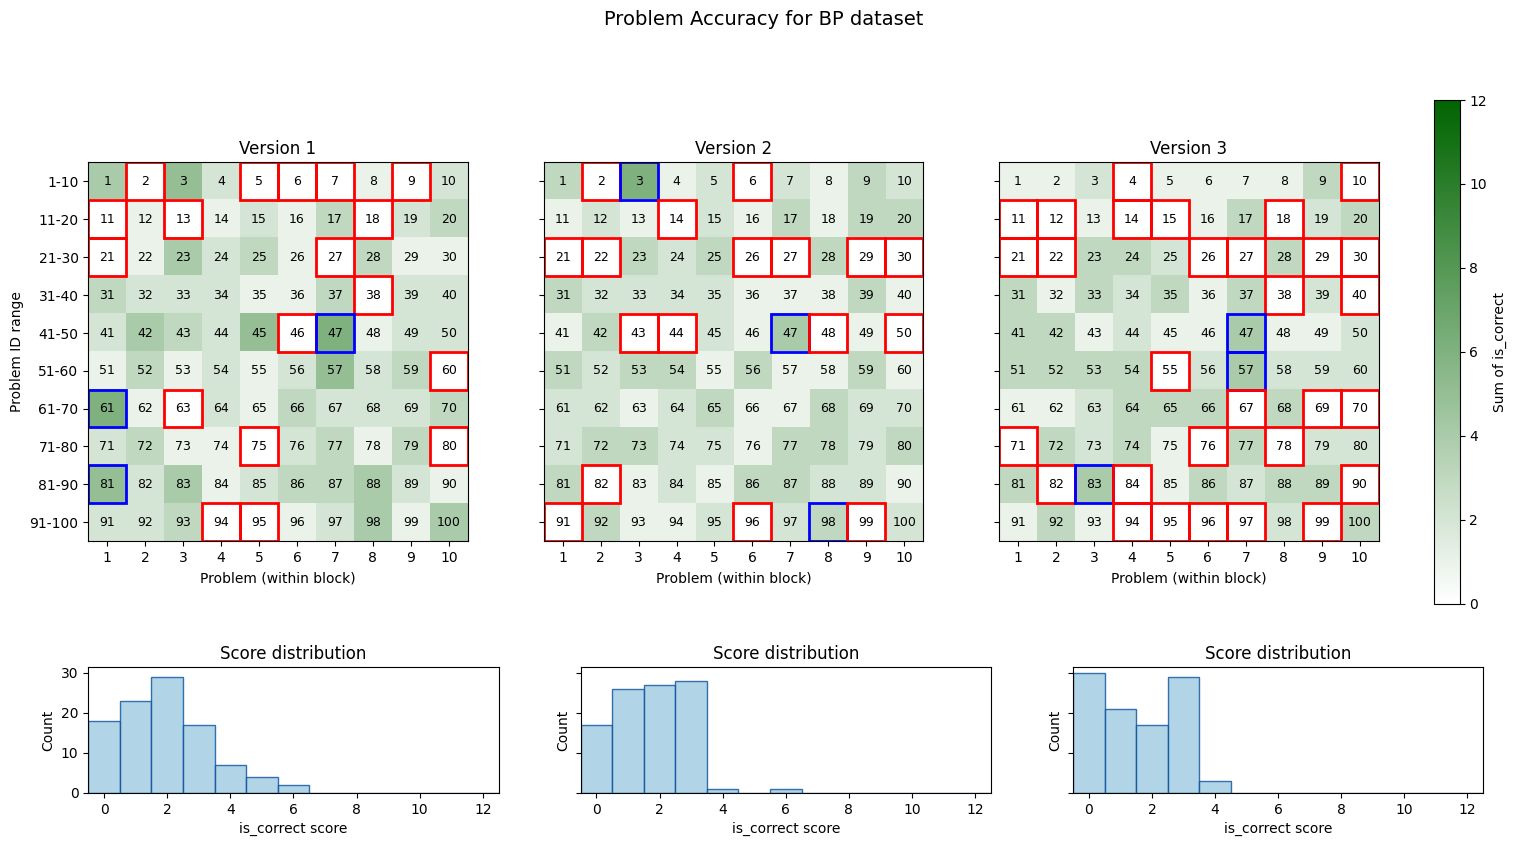

In [162]:
m1 = generate_10x10_result_matrix(df, dataset_name="bp", version=1)
m2 = generate_10x10_result_matrix(df, dataset_name="bp", version=2)
m3 = generate_10x10_result_matrix(df, dataset_name="bp", version=3)
plot_10x10_matrices_side_by_side([m1,m2,m3], ["Version 1","Version 2","Version 3"], max_score=12, main_title = "Problem Accuracy for BP dataset", highlight_extremes=True, zero_indexed_problem_ids=False)


Version 1
---------
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 81 : 8.0
  → 61 : 8.5
  → 47 : 8.5
Total score          : 471 / 1200
Percentage achieved  : 39.25%

Version 2
---------
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 59 : 7.5
  → 72 : 7.5
  → 3 : 8.5
Total score          : 461 / 1200
Percentage achieved  : 38.42%

Version 3
---------
Zero-value problems : 0
  → None
Top 3 problems (problem_id : is_correct)
  → 86 : 7.5
  → 77 : 7.5
  → 83 : 8.0
Total score          : 465 / 1200
Percentage achieved  : 38.79%


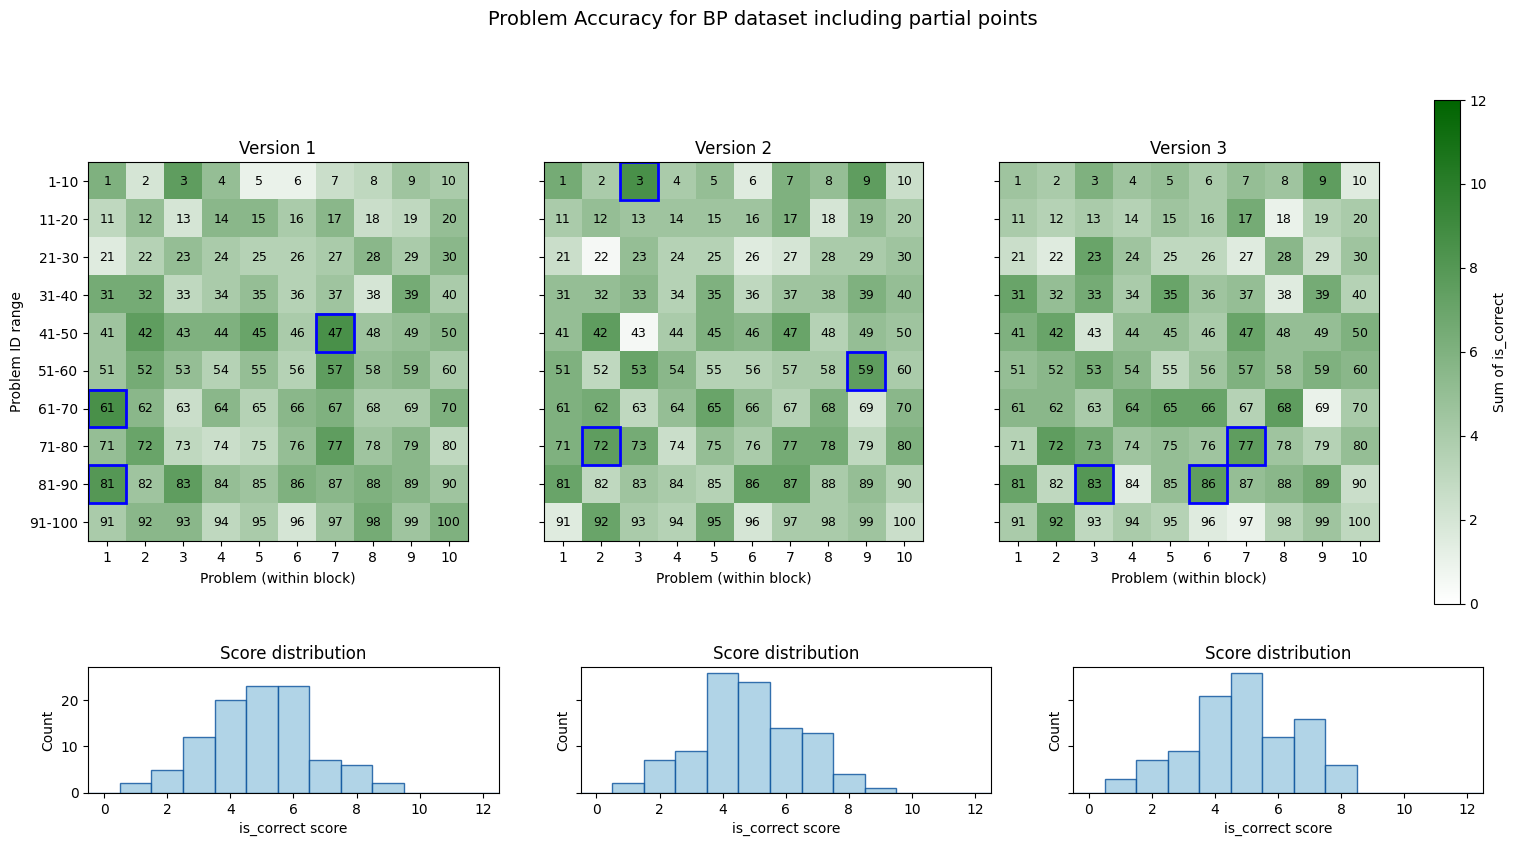

In [163]:
m1 = generate_10x10_result_matrix(df_half_bp, dataset_name="bp", version=1)
m2 = generate_10x10_result_matrix(df_half_bp, dataset_name="bp", version=2)
m3 = generate_10x10_result_matrix(df_half_bp, dataset_name="bp", version=3)
plot_10x10_matrices_side_by_side([m1,m2,m3], ["Version 1","Version 2","Version 3"], max_score=12, main_title = "Problem Accuracy for BP dataset including partial points", highlight_extremes=True)

#### matrices for cvr


Version 1
---------
Zero-value problems : 3
  → [43, 91, 99]
Top 3 problems (problem_id : is_correct)
  → 56 : 7
  → 79 : 7
  → 81 : 8
Total score          : 339 / 1200
Percentage achieved  : 28.25%

Version 3
---------
Zero-value problems : 3
  → [58, 60, 99]
Top 3 problems (problem_id : is_correct)
  → 12 : 7
  → 57 : 7
  → 63 : 8
Total score          : 349 / 1200
Percentage achieved  : 29.08%


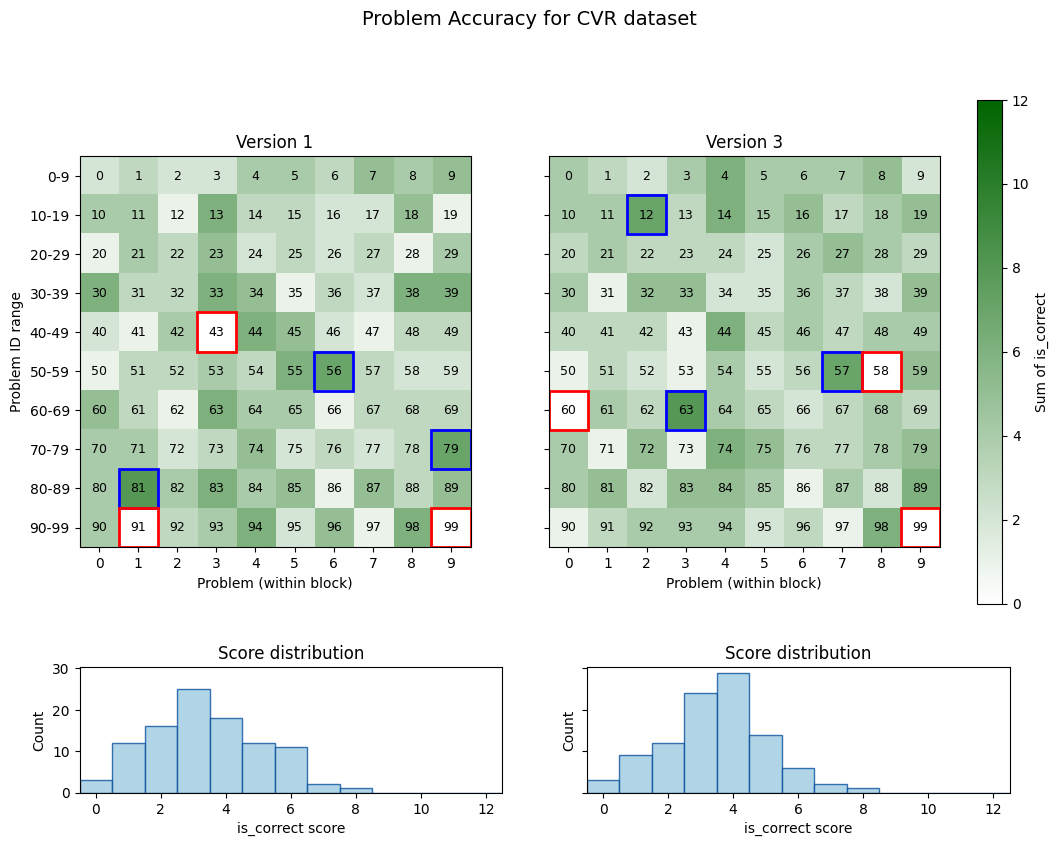

In [164]:
m1 = generate_10x10_result_matrix(df, dataset_name="cvr", version=1)
m3 = generate_10x10_result_matrix(df, dataset_name="cvr", version=3)
plot_10x10_matrices_side_by_side([m1,m3], ["Version 1","Version 3"], max_score=12, main_title = "Problem Accuracy for CVR dataset", highlight_extremes=True, zero_indexed_problem_ids=True)

#### matrices for raven


Version 1
---------
Zero-value problems : 3
  → [37, 74, 99]
Top 3 problems (problem_id : is_correct)
  → 67 : 5
  → 53 : 6
  → 54 : 6
Total score          : 298 / 1200
Percentage achieved  : 24.83%

Version 3
---------
Zero-value problems : 5
  → [37, 72, 86, 95, 99]
Top 3 problems (problem_id : is_correct)
  → 5 : 6
  → 20 : 6
  → 85 : 6
Total score          : 313 / 1200
Percentage achieved  : 26.08%


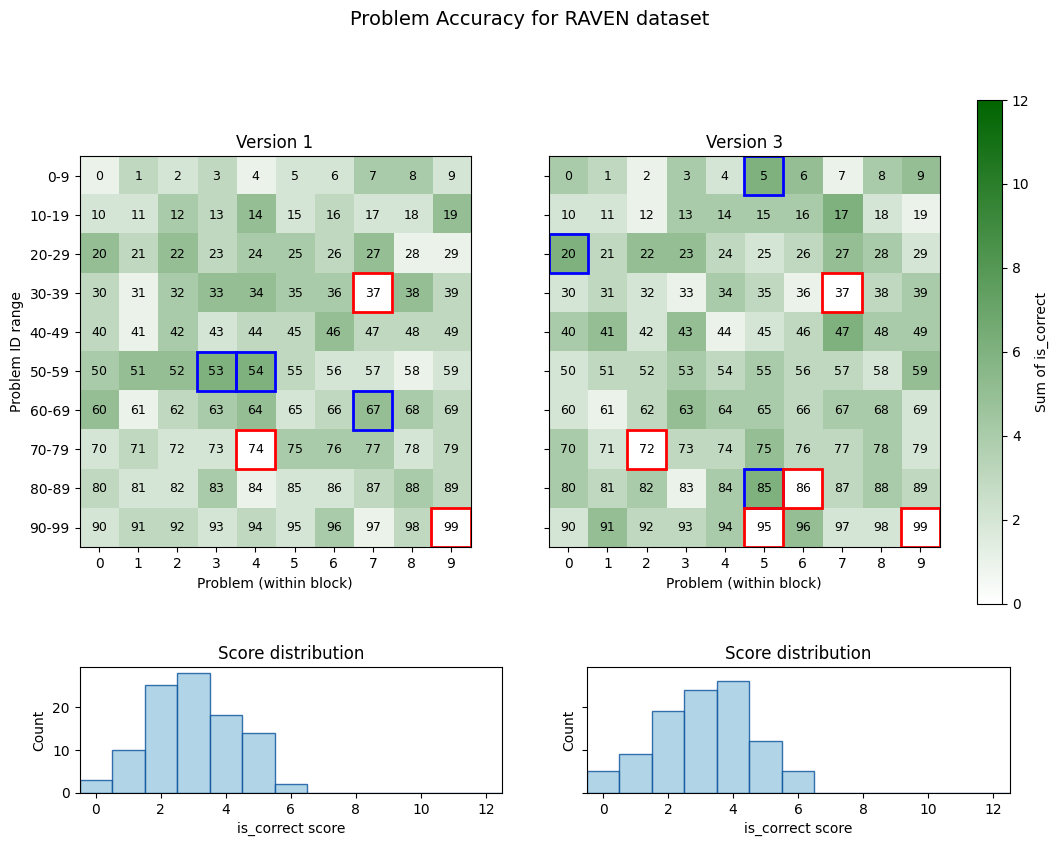

In [165]:
m1 = generate_10x10_result_matrix(df, dataset_name="raven", version=1)
m3 = generate_10x10_result_matrix(df, dataset_name="raven", version=3)
plot_10x10_matrices_side_by_side([m1,m3], ["Version 1","Version 3"], max_score=12, main_title = "Problem Accuracy for RAVEN dataset", highlight_extremes=True, zero_indexed_problem_ids=True)

#### matrices for mars


Ver 1
-----
Zero-value problems : 5
  → [28, 44, 60, 96, 99]
Top 3 problems (problem_id : is_correct)
  → 39 : 7
  → 87 : 7
  → 70 : 7
Total score          : 312 / 1200
Percentage achieved  : 26.00%

Ver3
----
Zero-value problems : 2
  → [67, 99]
Top 3 problems (problem_id : is_correct)
  → 44 : 6
  → 72 : 7
  → 58 : 8
Total score          : 329 / 1200
Percentage achieved  : 27.42%


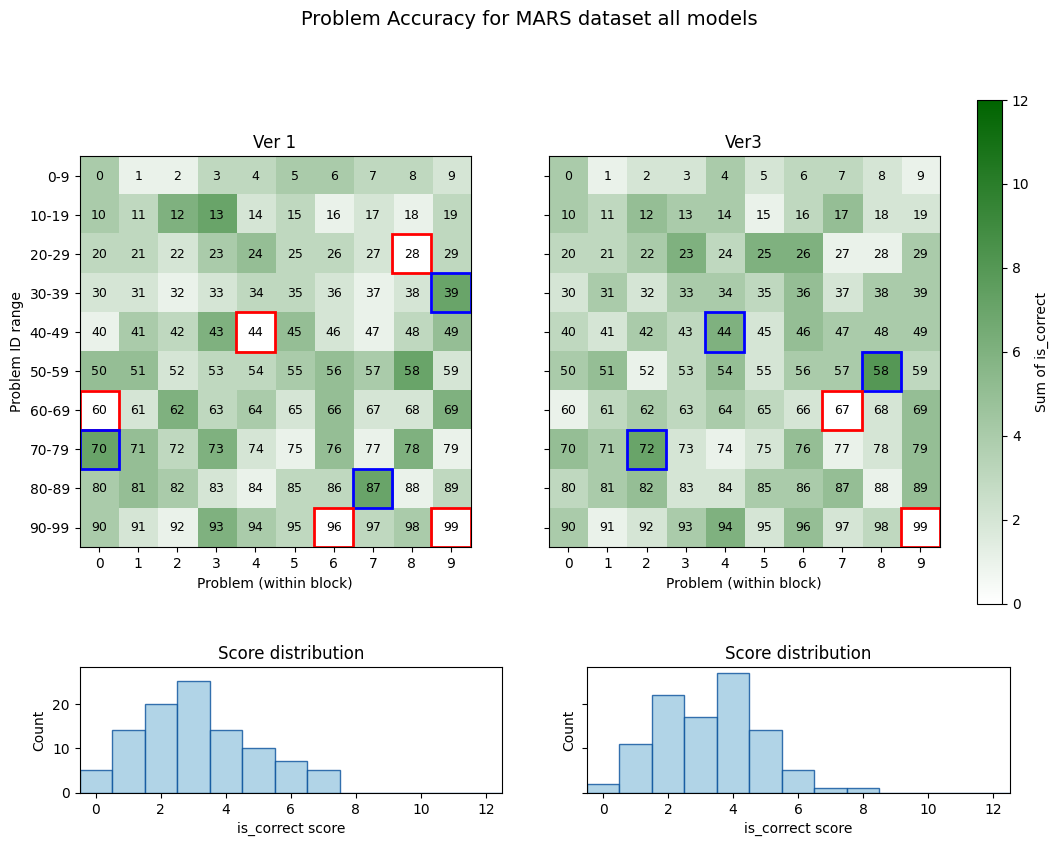

In [174]:
m_v1 = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=1)
m_v3 = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=3)
plot_10x10_matrices_side_by_side([m_v1, m_v3],["Ver 1", "Ver3"],  max_score=12, main_title = "Problem Accuracy for MARS dataset all models", highlight_extremes=True, zero_indexed_problem_ids=True)


Qwen
----
Zero-value problems : 33
  → [0, 1, 2, 3, 8, 9, 16, 20, 27, 28, 30, 32, 33, 36, 37, 41, 42, 44, 47, 52, 53, 59, 60, 61, 63, 83, 85, 86, 88, 91, 92, 96, 99]
Top 3 problems (problem_id : is_correct)
  → 98 : 3
  → 69 : 4
  → 78 : 4
Total score          : 116 / 400
Percentage achieved  : 29.00%

Intern
------
Zero-value problems : 41
  → [1, 7, 10, 14, 15, 16, 17, 18, 21, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 37, 38, 40, 44, 46, 47, 50, 60, 74, 75, 76, 77, 79, 82, 83, 84, 88, 89, 92, 96, 98, 99]
Top 3 problems (problem_id : is_correct)
  → 51 : 3
  → 12 : 3
  → 20 : 3
Total score          : 94 / 400
Percentage achieved  : 23.50%

Llava
-----
Zero-value problems : 33
  → [2, 4, 8, 11, 12, 15, 18, 20, 22, 28, 30, 35, 40, 44, 48, 51, 54, 59, 60, 64, 65, 66, 67, 68, 72, 75, 77, 79, 84, 95, 96, 97, 99]
Top 3 problems (problem_id : is_correct)
  → 45 : 3
  → 39 : 3
  → 70 : 3
Total score          : 102 / 400
Percentage achieved  : 25.50%


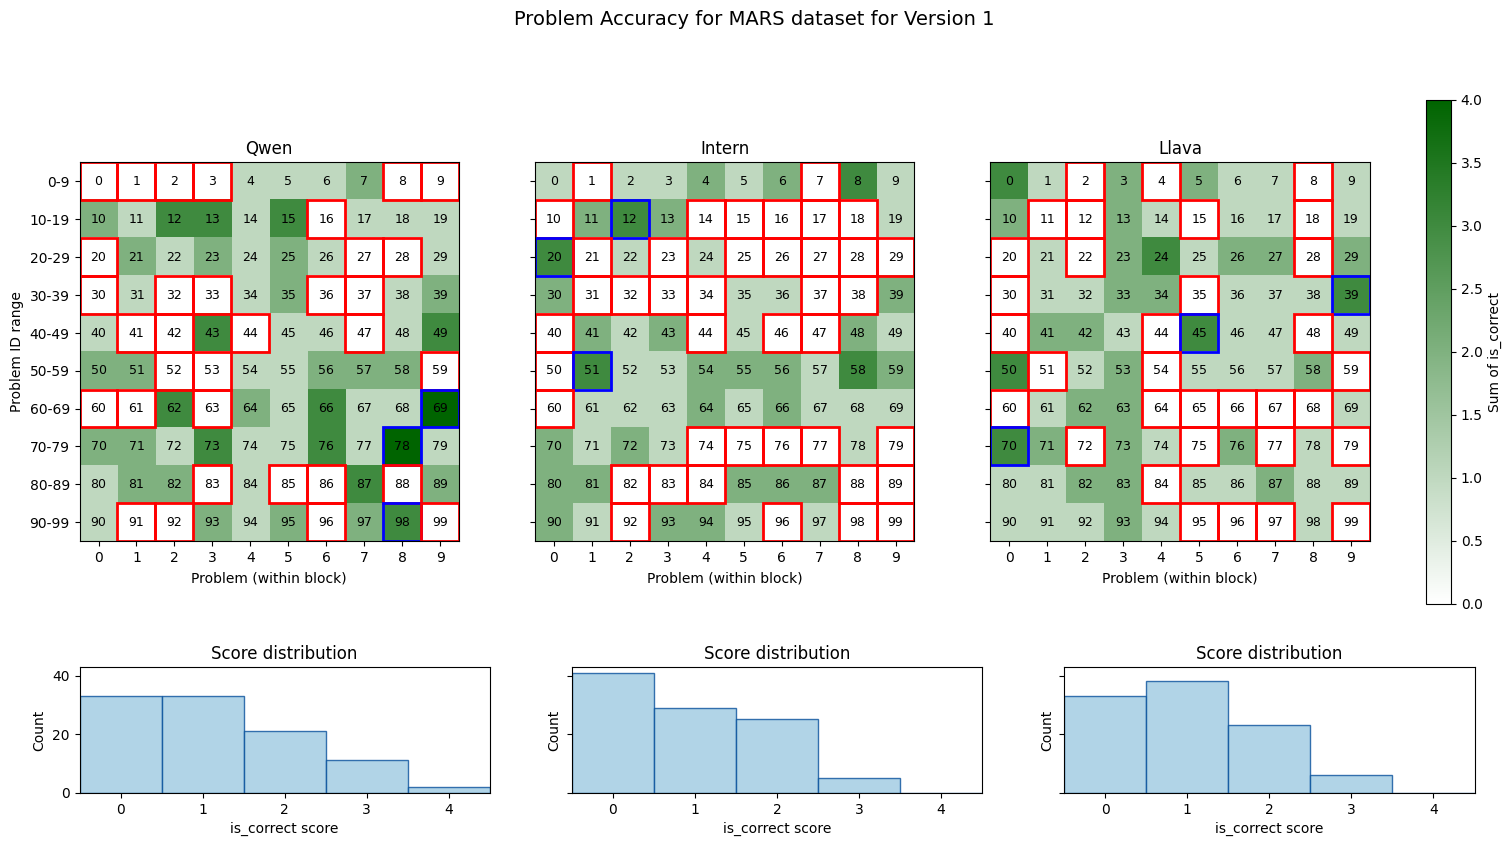


Qwen
----
Zero-value problems : 31
  → [0, 1, 2, 8, 16, 24, 27, 28, 30, 31, 37, 40, 41, 42, 45, 48, 52, 55, 61, 63, 67, 74, 75, 78, 80, 86, 90, 91, 92, 96, 99]
Top 3 problems (problem_id : is_correct)
  → 49 : 4
  → 87 : 4
  → 72 : 4
Total score          : 121 / 400
Percentage achieved  : 30.25%

Intern
------
Zero-value problems : 30
  → [1, 5, 9, 15, 19, 20, 22, 24, 32, 33, 37, 39, 43, 46, 49, 59, 60, 62, 66, 67, 68, 73, 74, 77, 83, 84, 88, 91, 97, 99]
Top 3 problems (problem_id : is_correct)
  → 58 : 3
  → 96 : 3
  → 48 : 4
Total score          : 108 / 400
Percentage achieved  : 27.00%

Llava
-----
Zero-value problems : 33
  → [3, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21, 27, 28, 30, 32, 35, 38, 43, 48, 49, 52, 54, 60, 66, 67, 75, 77, 84, 87, 88, 95, 98, 99]
Top 3 problems (problem_id : is_correct)
  → 42 : 3
  → 46 : 3
  → 90 : 3
Total score          : 100 / 400
Percentage achieved  : 25.00%


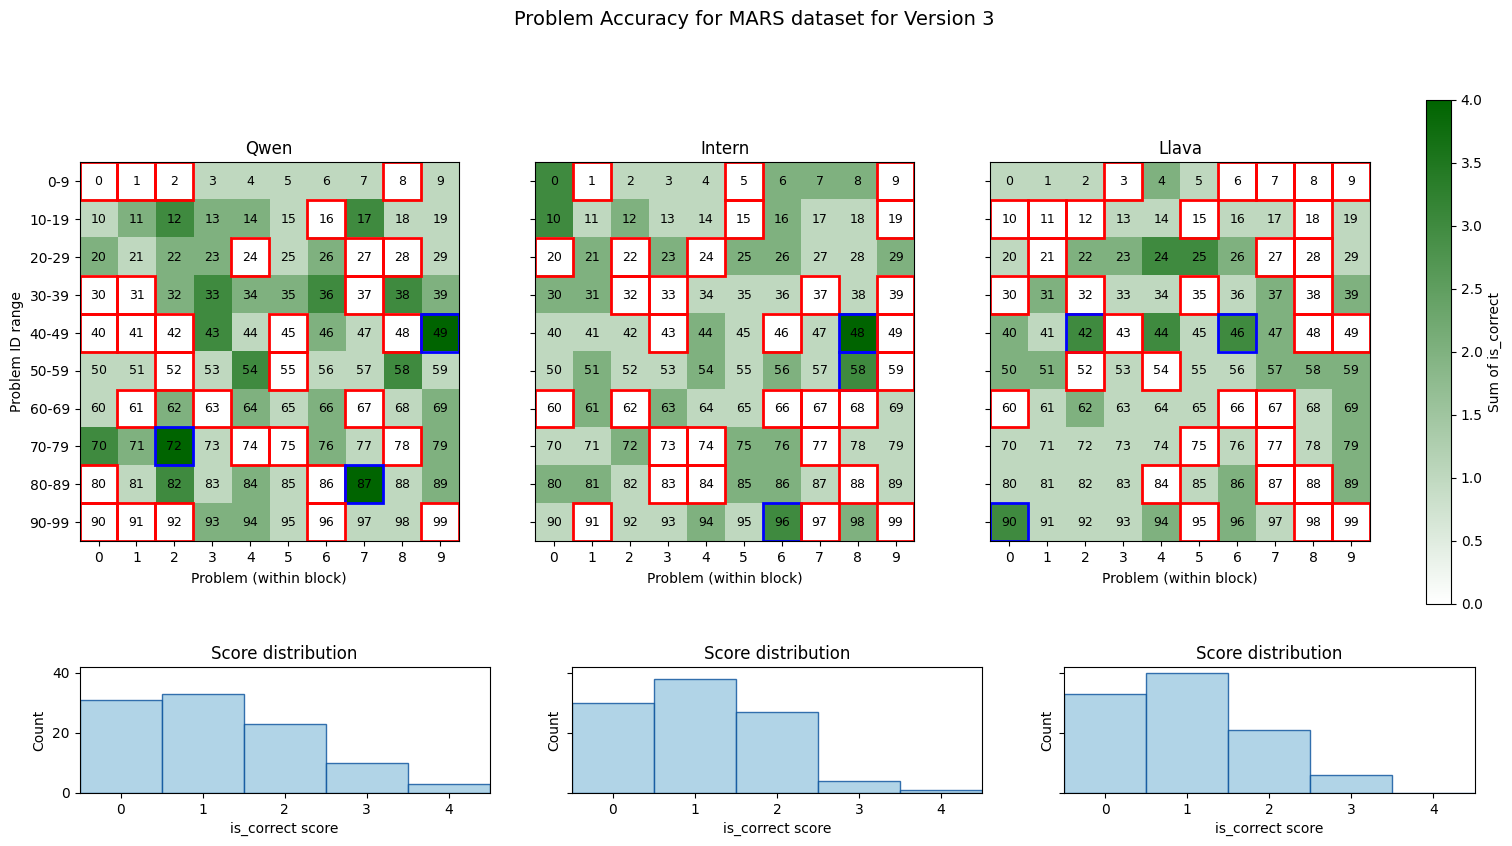

In [173]:
m1_qwen = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=1, model_name="Qwen/Qwen2.5-VL-7B-Instruct")
m3_qwen = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=3, model_name="Qwen/Qwen2.5-VL-7B-Instruct")
#plot_10x10_matrices_side_by_side([m1_qwen,m3_qwen], ["Version 1","Version 3"], max_score=4, main_title = "Problem Accuracy for MARS dataset using Qwen", highlight_extremes=True, zero_indexed_problem_ids=True)

m1_intern = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=1, model_name="OpenGVLab/InternVL3-8B")
m3_intern = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=3, model_name="OpenGVLab/InternVL3-8B")
#plot_10x10_matrices_side_by_side([m1_intern,m3_intern], ["Version 1","Version 3"], max_score=4, main_title = "Problem Accuracy for MARS dataset using Intern", highlight_extremes=True, zero_indexed_problem_ids=True)

m1_llava = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=1, model_name="llava-hf/llava-v1.6-mistral-7b-hf")
m3_llava = generate_10x10_result_matrix(df, dataset_name="marsvqa", version=3, model_name="llava-hf/llava-v1.6-mistral-7b-hf")
#plot_10x10_matrices_side_by_side([m1_llava,m3_llava], ["Version 1","Version 3"], max_score=4, main_title = "Problem Accuracy for MARS dataset using Llava", highlight_extremes=True, zero_indexed_problem_ids=True)


plot_10x10_matrices_side_by_side([m1_qwen, m1_intern, m1_llava], ["Qwen", "Intern", "Llava"], max_score=4, main_title = "Problem Accuracy for MARS dataset for Version 1", highlight_extremes=True, zero_indexed_problem_ids=True)
plot_10x10_matrices_side_by_side([m3_qwen, m3_intern, m3_llava], ["Qwen", "Intern", "Llava"], max_score=4, main_title = "Problem Accuracy for MARS dataset for Version 3", highlight_extremes=True, zero_indexed_problem_ids=True)